# EMA context exploration

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>


## Notebook setup

### Imports

In [1]:
%matplotlib inline

# base utilities
import os
import pickle
import random

# data manipulation
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, ttest_ind

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, display_html

# user imports
from utils.process_data import *
from utils.stats import *

# rpy 
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
lmtest = importr('lmtest')
Hmisc = importr("Hmisc")
pandas2ri.activate()

### JS scripts

In [2]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

### Display

In [4]:
sns.set_palette(sns.color_palette('colorblind'))

## Sandbox

### Build data

In [ ]:
timezones = pd.read_csv('CS120/timezones.csv', sep='\t', header=None, 
                       names=['pid', 'offset'])
tz_dict = timezones.set_index('pid').to_dict()['offset']
timezones.head()

In [ ]:
pid = '1183252'
emm_cols = ['stress', 'mood', 'energy', 'focus']

emm_test = pd.read_csv(csv_files['emm'].format(pid), sep='\t', header=None,
                      names=csv_headers['emm'])
print(emm_test.shape)
emm_test = emm_test.drop_duplicates()
print(emm_test.shape)
print(emm_test['stress'].describe())
emm_test['time'] = pd.to_datetime(emm_test['timestamp'], unit='s')
emm_test['time'] = emm_test.apply(lambda x: x.time + pd.Timedelta(tz_dict[pid], unit='h'), axis=1)

emm_test['date'] = pd.DatetimeIndex(emm_test['time']).normalize()

for col in emm_cols:
    emm_test = z_score(emm_test, col)
    
display(emm_test.loc[emm_test['date'] >= '2015-11-23'])

In [234]:
# build the DataFrame

def z_score(df, in_col):
    """
    computes the z-score of the given column
    """
    df['z_' + in_col] = (df[in_col] - df[in_col].mean()) / df[in_col].std()
    return df

def process_emm_raw(pid, unit='s'):
    """Processes the given participants's emm.csv file.
    
    Adds date (correcting for timezone), pid columns and standardization columns.
    
    Args:
        emm_df (pandas.DataFrame): the raw emm_df loaded from csv
        pid (str): the participant id
    
    Returns:
        pandas.Dataframe: converted Dataframe with columns: [pid, timestamp, stress, mood, energy, focus, time, date]
    """
    emm_cols = ['stress', 'mood', 'energy', 'focus']
    emm_df = pd.read_csv(csv_files['emm'].format(pid), sep='\t', header=None,
                      names=csv_headers['emm'])
    emm_df = emm_df.drop_duplicates()
    emm_df['time'] = pd.to_datetime(emm_df['timestamp'], unit=unit)
    emm_df['time'] = emm_df.apply(lambda x: x.time + pd.Timedelta(tz_dict[pid], unit='h'), axis=1)

    emm_df['date'] = pd.DatetimeIndex(emm_df['time']).normalize()
    emm_df['pid'] = pid
  
    for col in emm_cols:
        emm_df = z_score(emm_df, col)
    
    return emm_df

In [ ]:
# process all participants, only needs to be done once
emm_df = pd.DataFrame()
pids = id_dirs.copy()
pids.remove('1496251') # this participant is missing timezone data

for pid in pids:
        csv_path = csv_files['emm'].format(pid)
        if os.path.exists(csv_path):
            df = process_emm(pid)
            emm_df = emm_df.append(df)
            print(pid)
            
#pickle.dump(emm_df, open("pkl/emm.df", "wb"), -1)

In [ ]:
emm_df = pickle.load(open("pkl/emm.df", "rb"))

In [ ]:
screener_df = get_screener_df()
group_cols = ['CONTROL', 'ANXIOUS', 'DEPRESSED', 'DEPRESSED_ANXIOUS'] 
screener_df[group_cols] = screener_df[group_cols].fillna(0)

def group_map(row):
    if row['ANXIOUS'] == 1:
        return 'anxious'
    if row['CONTROL'] == 1:
        return 'control'
    if row['DEPRESSED'] == 1:
        return 'depressed'
    if row['DEPRESSED_ANXIOUS'] == 1:
        return 'depressed_anxious'


screener_df['group'] = screener_df.apply(group_map, axis=1)

In [ ]:
screener_df.head()

In [ ]:
emm_df = emm_df.merge(screener_df, on='pid', how='left')

In [ ]:
control_emm = emm_df.loc[emm_df['CONTROL'] == 1]
print(control_emm.drop_duplicates('pid').shape[0])

anxious_emm = emm_df.loc[emm_df['ANXIOUS'] == 1]
print(anxious_emm.drop_duplicates('pid').shape[0])

depress_emm = emm_df.loc[emm_df['DEPRESSED'] == 1]
print(depress_emm.drop_duplicates('pid').shape[0])

dep_anx_emm = emm_df.loc[emm_df['DEPRESSED_ANXIOUS'] == 1]
print(dep_anx_emm.drop_duplicates('pid').shape[0])

In [ ]:
emm_df.loc[emm_df['date'] == '2015-12-02']['mood'].describe()

In [ ]:
emm_df['hour'] = emm_df['time'].dt.hour + (emm_df['time'].dt.minute / 60)

In [ ]:
emm_df['emm_idx'] = emm_df.groupby(['pid', 'date'], as_index=False).cumcount()

In [ ]:
emm_df.head()

# builds a dict of lists for the dates with complete EMA responses (all 3)

complete_dates = emm_df.groupby(['pid', 'date'], as_index=False)['emm_idx'].sum()
complete_dates = complete_dates.loc[complete_dates['emm_idx'] == 3]
complete_dates.head()
complete_date_dict = {k: list(v) for k,v in complete_dates.groupby('pid')['date']}

def check_date(row):
    """df.apply function to check for rows that are part of a complete day.
    """
    if  row['pid'] in complete_date_dict:
        return row['date'] in complete_date_dict[row['pid']]
    else:
        return False


complete_date_emm = emm_df[emm_df.apply(check_date, axis=1)]

In [ ]:
# builds a dict of lists of tuples (date, # complete) for the dates with missing EMAs

temp_df = emm_df.drop_duplicates(subset=['pid', 'date'])
pids = emm_df['pid'].unique()

missing_date_dict = {}
total_days_dict = {}


for pid in pids:
    # figure out which dates have 0 EMA responses
    pid_dict = missing_date_dict.get(pid)
    if pid_dict is None:
        pid_dict = {}
        missing_date_dict[pid] = pid_dict
        
    pid_df = temp_df.loc[temp_df['pid'] == pid]
    
    # fill in all dates between the first and last date    
    idx = pd.date_range(pid_df['date'].min(), pid_df['date'].max())
    s = pid_df[['date', 'timestamp']].squeeze()
    s = s.set_index('date')
    s = s.reindex(idx, fill_value=np.nan)
    # count total number of days in the study
    total_days_dict[pid] = s.shape[0]
    
    # find which dates are missing
    missing_dates = s[s['timestamp'].isna()].index.values
    for date in missing_dates:
        pid_dict[date] = 0

assert len(total_days_dict) == len(pids)
        
# figure out which dates have < 3 EMA responses
missing_dates = emm_df.groupby(['pid', 'date'], as_index=False)['emm_idx'].sum()
missing_dates = missing_dates.loc[missing_dates['emm_idx'] < 3]
pids = missing_dates['pid'].unique()

for pid in pids:
    pid_df = missing_dates.loc[missing_dates['pid'] == pid]
    pid_dict = missing_date_dict[pid]
    for _, row in pid_df.iterrows():
        # plus 1 because emm_idx is zero indexed, so we can count # responded EMAs
        pid_dict[row['date']] = row['emm_idx'] + 1
        


In [ ]:
# old miss/total calculation
# temp_df = emm_df.groupby(['pid', 'date'], as_index=False)['stress'].count()
# miss_day_count = temp_df.groupby('pid')['stress'].apply(lambda x: x[x < 3].count())
# tot_day_count = emm_df.groupby('pid')['date'].nunique()

tot_day_count = pd.Series(data=total_days_dict)
tot_day_count = tot_day_count.rename_axis(index='pid')
miss_day_count = pd.Series(data={k: len(v) for k,v in missing_date_dict.items()})
miss_day_count = miss_day_count.rename_axis(index='pid')

#print(miss_day_count.head())

In [ ]:
no_ema_count_dict = {}

for pid, date_dict in missing_date_dict.items():
    zero_count = 0
    for ts, num_emas in date_dict.items():
        if num_emas == 0:
            zero_count += 1
    no_ema_count_dict[pid] = zero_count
    
no_ema_count = pd.Series(data=no_ema_count_dict)
no_ema_count = no_ema_count.rename_axis(index='pid')

In [ ]:
context_df = pd.DataFrame()
context_df['pct_missing_emm_days'] = miss_day_count / tot_day_count
context_df['pct_no_emm_days'] = no_ema_count / tot_day_count

context_df = context_df.reset_index()
context_df = context_df.merge(screener_df[['pid', 'group']], on='pid', how='left')
display(context_df.loc[context_df['pid'].isin(['1002060', '1579481', '1425272', '984221'])])

In [ ]:
# get mean and variance of emm completion
complete_date_mean = complete_date_emm.groupby(['pid', 'emm_idx'])['hour'] \
                                        .mean() \
                                        .unstack(level=1) \
                                        .add_suffix("_mean_emm") \
                                        .reset_index()

complete_date_std = complete_date_emm.groupby(['pid', 'emm_idx'])['hour'] \
                                        .std() \
                                        .unstack(level=1) \
                                        .add_suffix("_std_emm") \
                                        .reset_index()
context_df = context_df.merge(complete_date_mean, on='pid', how='left')
context_df = context_df.merge(complete_date_std, on='pid', how='left')

In [210]:
# add emm scores by EMM response time
emm_cols  = ['mood', 'stress', 'focus', 'energy']

for emm in emm_cols:
    complete_date_mean_emm = complete_date_emm.groupby(['pid', 'emm_idx'])[emm] \
                                            .mean() \
                                            .unstack(level=1) \
                                            .add_suffix("_mean_" + emm) \
                                            .reset_index()

    complete_date_mean_z_emm = complete_date_emm.groupby(['pid', 'emm_idx'])["z_" + emm] \
                                            .mean() \
                                            .unstack(level=1) \
                                            .add_suffix("_mean_z_" + emm) \
                                            .reset_index()
    
    #context_df = context_df.merge(complete_date_mean_emm, on='pid', how='left')
    context_df = context_df.merge(complete_date_mean_z_emm, on='pid', how='left')

### Other sensor modalities

In [ ]:
# load processed daily data
emm = pickle.load(open('data/emm.df', 'rb'))
scr = pickle.load(open('data/scr.df', 'rb'))
tch = pickle.load(open('data/tch.df', 'rb'))
ems = pickle.load(open('data/ems.df', 'rb'))
coe = pickle.load(open('data/coe_new.df', 'rb'))
app = pickle.load(open('data/app.df', 'rb'))
run_fb = pickle.load(open('data/run_fb.df', 'rb'))
run_email = pickle.load(open('data/run_email.df', 'rb'))
act = pickle.load(open('data/act_test.df', 'rb'))

emm_cols = ['mood', 'stress', 'energy', 'focus']
ems_cols = ['sleep_amount', 'sleep_quality']
coe_cols = ['call_in_count', 'call_out_count', 'sms_in_count', 'sms_out_count']
act_cols = ['IN_VEHICLE', 'ON_BICYCLE', 'ON_FOOT', 'STILL', 'TILTING', 'UNKNOWN']
fus_cols = ['entropy', 'norm_entropy', 'cluster', 'loc_var']

ems_raw =  process_csv_all_daily('ems', normalize=False)
ems_raw['sleep_amount'] = ems_raw['sleep_amount'] / (1000*60*60)
ems_raw['sleep_quality'] = ems_raw['sleep_quality'].astype(int)

emm_raw =  process_csv_all_daily('emm', normalize=False)

fus = pickle.load(open('data/fus.df', 'rb'))
fus['norm_entropy'] = fus['entropy'] / fus['cluster']

In [ ]:
pids = id_dirs.copy()
pids.remove('1496251') # missing timezone data

In [233]:
# processes the fus.csv, only needs to be done once.
time_col = 'timestamp'
day_col = 'date'
csv_name = 'fus'  

def pooled_fus(pid):
    csv_path = csv_files[csv_name].format(pid)
    if os.path.exists(csv_path):
        print(pid)
        df = pd.read_csv(csv_path, sep='\t', header=None, 
                          names=csv_headers[csv_name])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df['timestamp'] = df.apply(lambda x: x.timestamp + pd.Timedelta(tz_dict[pid], unit='h'), axis=1)

        df[day_col] = pd.DatetimeIndex(pd.to_datetime(df[time_col], unit='s')).normalize()
        df['pid'] = pid
        fus_day = process_fus(df, 0.5)
        return fus_day
        
from multiprocessing import Pool

with Pool(8) as pool:
    results = pool.map(pooled_fus, pids)

    
all_fus = pd.DataFrame()
for df in results:
    all_fus = all_fus.append(df)
    
#pickle.dump(all_fus, open("pkl/fus.df", "wb"),-1)

1002060
1126979
1165040
1079411
1054952
1145713
1210517
1186533
1229114
1288818
1327952
1370566


Process ForkPoolWorker-33:
Process ForkPoolWorker-40:
Process ForkPoolWorker-39:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tliu/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tliu/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-36:
  File "/home/tliu/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/tliu/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
Process ForkPoolWorker-38:
Traceback (most recent call last):
  File "/home/tliu/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "<ipython-input-233-acfa244b31a2>", line 13, 

  File "/home/tliu/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "pandas/_libs/properties.pyx", line 36, in pandas._libs.properties.CachedProperty.__get__
  File "/home/tliu/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/apply.py", line 99, in values
    return self.obj.values
  File "<ipython-input-233-acfa244b31a2>", line 13, in pooled_fus
    df['timestamp'] = df.apply(lambda x: x.timestamp + pd.Timedelta(tz_dict[pid], unit='h'), axis=1)
  File "/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py", line 5325, in values
    return self._data.as_array(transpose=self._AXIS_REVERSED)
  File "/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 768, in as_array
    arr = mgr._interleave()
  File "/home/tliu/.

KeyboardInterrupt: 

In [ ]:
all_fus.loc[all_fus['pid'] == '1002060'].head(10)

In [ ]:
fus.head(10)

In [ ]:
all_act = pd.DataFrame()
def process_act_map(pid):
    csv_name = 'act'
    csv_path = csv_files[csv_name].format(pid)
    if os.path.exists(csv_path):
        print(pid)
        df = pd.read_csv(csv_path, sep='\t', header=None, 
                          names=csv_headers[csv_name])
        emm_df['timestamp'] = pd.to_datetime(emm_df['timestamp'], unit='s')
        emm_df['timestamp'] = emm_df.apply(lambda x: x.timestamp + pd.Timedelta(tz_dict[pid], unit='h'), axis=1)

        df[day_col] = pd.DatetimeIndex(pd.to_datetime(df[time_col], unit='s')).normalize()
        df['pid'] = pid
        act_day = process_act(df, pid)
        return act_day
     
with Pool(8) as pool:
    act_results = pool.map(process_act_map, pids)

In [201]:
emm_day_df = emm_df.copy()

# exclude days that were part of a missing day rollover
keep_dates = emm_df.groupby(['pid', 'date'], as_index=False)['emm_idx'].sum()
keep_dates = keep_dates.loc[keep_dates['emm_idx'] <= 3]
keep_dates.head()
keep_date_dict = {k: list(v) for k,v in keep_dates.groupby('pid')['date']}

def check_date(row):
    """df.apply function to check for rows that are part of a keep day.
    """
    if  row['pid'] in keep_date_dict:
        return row['date'] in keep_date_dict[row['pid']]
    else:
        return False


emm_day_df = emm_day_df[emm_day_df.apply(check_date, axis=1)]
emm_day_df = emm_day_df.groupby(['pid', 'date'], as_index=False).mean()
emm_day_df = emm_day_df.drop(['timestamp', 'hour'], axis='columns')

In [202]:
emm_day_df['missing_ema'] = (emm_day_df['emm_idx'] < 1).astype(int)
emm_day_df = emm_day_df.drop(['emm_idx'], axis='columns')

In [203]:
fus = pickle.load(open("pkl/fus.df", "rb"))
act = pickle.load(open("pkl/act.df", "rb"))

fus['norm_entropy'] = fus['entropy'] / fus['cluster']

In [204]:
act = act.drop(["UNKNOWN", "ACT_TOTALS"], axis='columns')

In [205]:
emm_day_df = emm_day_df.merge(act, on=['pid', 'date'], how='left')
emm_day_df = emm_day_df.merge(fus, on=['pid', 'date'], how='left')

## Plots

### Functions

In [236]:
context_df.head()

,pid,pct_missing_emm_days,pct_no_emm_days,group,0_mean_emm,1_mean_emm,2_mean_emm,0_std_emm,1_std_emm,2_std_emm,...,2_mean_z_mood,0_mean_z_stress,1_mean_z_stress,2_mean_z_stress,0_mean_z_focus,1_mean_z_focus,2_mean_z_focus,0_mean_z_energy,1_mean_z_energy,2_mean_z_energy
0,1579481,0.068966,0.000000,depressed_anxious,9.415686,14.355556,20.930719,0.576574,0.327748,0.513435,...,0.269214,-0.067587,-0.246100,0.356381,-0.004702,0.014665,0.092134,-0.071721,0.072555,0.162728
1,1425272,0.216216,0.108108,depressed,9.544048,14.763690,21.019643,2.262361,1.505559,1.060593,...,0.182141,-0.159682,0.085784,0.036691,-0.108431,-0.060296,0.372920,-0.208587,-0.049424,0.348483
2,984221,0.040000,0.020000,control,9.332292,14.542014,20.804861,1.113077,0.665930,0.563927,...,0.167685,-0.223128,-0.097295,0.266222,-0.148602,0.065394,0.032471,-0.167603,0.100971,0.011446
3,1145713,0.148148,0.000000,depressed,11.266667,14.524583,21.108750,1.355331,0.688561,0.932990,...,-0.106898,0.246871,0.088874,-0.227121,0.312951,0.393712,-0.494664,0.296649,0.406181,-0.269266
4,HE593LT,0.297297,0.000000,depressed,9.308333,14.957692,20.907051,0.364699,0.872738,0.311454,...,0.006987,0.150008,-0.372998,-0.316962,-0.224381,0.292847,-0.038179,0.079635,0.456881,-0.333540


In [66]:
def build_emm_response_plot(target):
    """Builds plots for the target EMA response.
    """
    fig, axes = plt.subplots(3,2, figsize=(8,8), sharex=True)

    for i in range(3):

        sns.catplot(x='group', 
                y="{}_mean_{}".format(i, target), 
                data=context_df, 
                kind="bar",
                ci=68,
                ax=axes[i, 0])
        sns.catplot(x='group', 
                y="{}_mean_z_{}".format(i, target), 
                data=context_df, 
                ci=68,
                kind="bar",
                ax=axes[i, 1])
        axes[i,0].set(ylim=(0, 7), ylabel="ema {} {}".format(i, target))
        axes[i,1].set(ylim=(-.2, .2), ylabel="ema {} z-{}".format(i, target))
        props = {"rotation" : 45, 'ha':'right'}
        plt.setp(axes[i,0].get_xticklabels(), **props)
        plt.setp(axes[i,1].get_xticklabels(), **props)
    # needed for bug with catplot
    for i in range(2, 8):
        plt.close(i)
    plt.suptitle("{} EMA responses across groups and survey order".format(target), fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    plt.show()

### Descriptive Stats

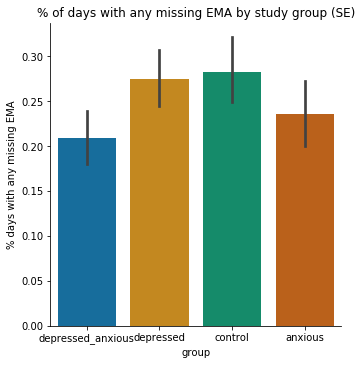

In [68]:
sns.catplot(x='group', 
            y='pct_missing_emm_days', 
            data=context_df, 
            kind="bar",
            ci=68)
plt.ylabel("% days with any missing EMA")
plt.title("% of days with any missing EMA by study group (SE)")
plt.show()

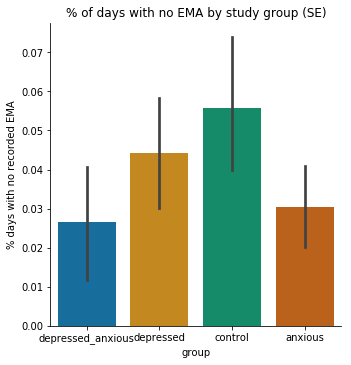

In [69]:
sns.catplot(x='group', 
            y='pct_no_emm_days', 
            data=context_df, 
            kind="bar",
            ci=68)
plt.ylabel("% days with no recorded EMA")
plt.title("% of days with no EMA by study group (SE)")
plt.show()

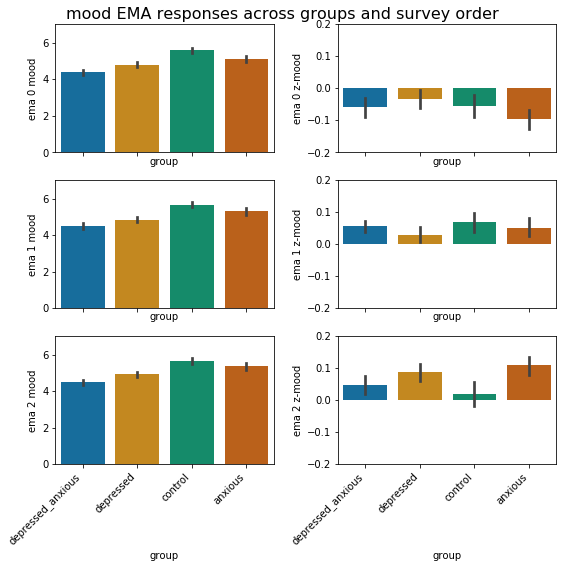

In [70]:
build_emm_response_plot("mood")

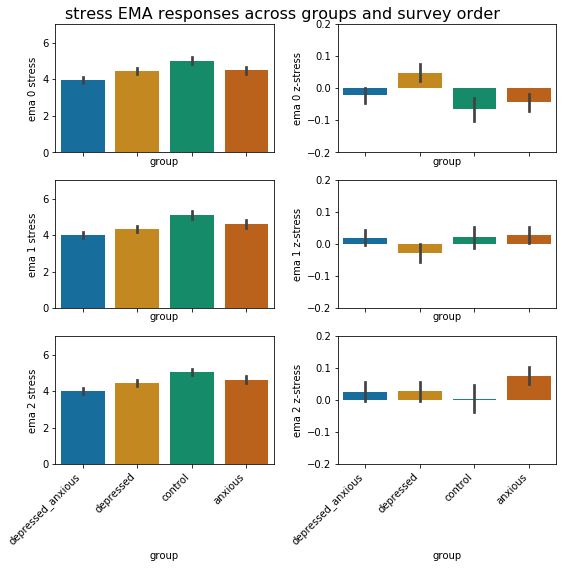

In [71]:
build_emm_response_plot('stress')

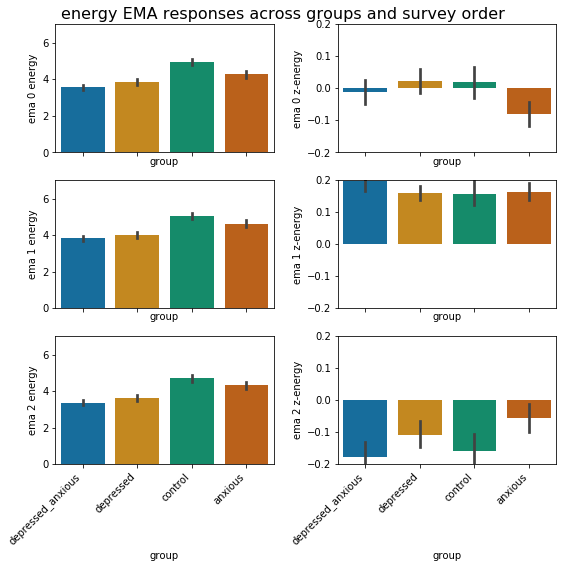

In [72]:
build_emm_response_plot('energy')

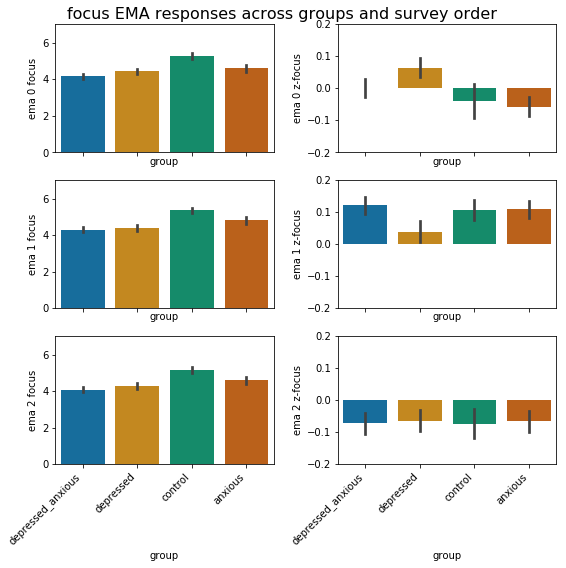

In [73]:
build_emm_response_plot('focus')

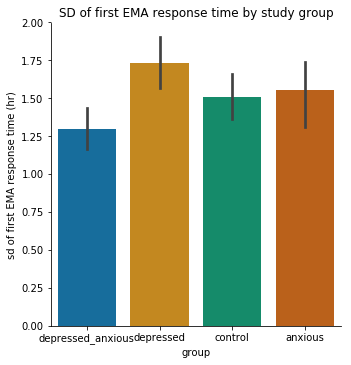

In [74]:
sns.catplot(x='group', 
            y='0_std_emm', 
            data=context_df,
            ci=68,
            kind="bar")
plt.ylabel("sd of first EMA response time (hr)")
plt.title("SD of first EMA response time by study group")
plt.show()

In [218]:
emm_df.loc[emm_df['emm_idx'] == 1]['hour'].describe()

count    10028.000000
mean        15.155832
std          2.659747
min          0.116667
25%         14.066667
50%         14.533333
75%         15.837500
max         23.983333
Name: hour, dtype: float64

In [226]:
emm_df.shape

(29389, 21)

In [225]:
complete_date_dict

{'1002060': [Timestamp('2015-11-04 00:00:00'),
  Timestamp('2015-11-05 00:00:00'),
  Timestamp('2015-11-06 00:00:00'),
  Timestamp('2015-11-07 00:00:00'),
  Timestamp('2015-11-08 00:00:00'),
  Timestamp('2015-11-09 00:00:00'),
  Timestamp('2015-11-10 00:00:00'),
  Timestamp('2015-11-11 00:00:00'),
  Timestamp('2015-11-12 00:00:00'),
  Timestamp('2015-11-13 00:00:00'),
  Timestamp('2015-11-14 00:00:00'),
  Timestamp('2015-11-15 00:00:00'),
  Timestamp('2015-11-16 00:00:00'),
  Timestamp('2015-11-17 00:00:00'),
  Timestamp('2015-11-18 00:00:00'),
  Timestamp('2015-11-19 00:00:00'),
  Timestamp('2015-11-20 00:00:00'),
  Timestamp('2015-11-21 00:00:00'),
  Timestamp('2015-11-22 00:00:00'),
  Timestamp('2015-11-25 00:00:00'),
  Timestamp('2015-11-26 00:00:00'),
  Timestamp('2015-11-27 00:00:00'),
  Timestamp('2015-11-29 00:00:00'),
  Timestamp('2015-11-30 00:00:00'),
  Timestamp('2015-12-01 00:00:00'),
  Timestamp('2015-12-02 00:00:00'),
  Timestamp('2015-12-03 00:00:00'),
  Timestamp('2015

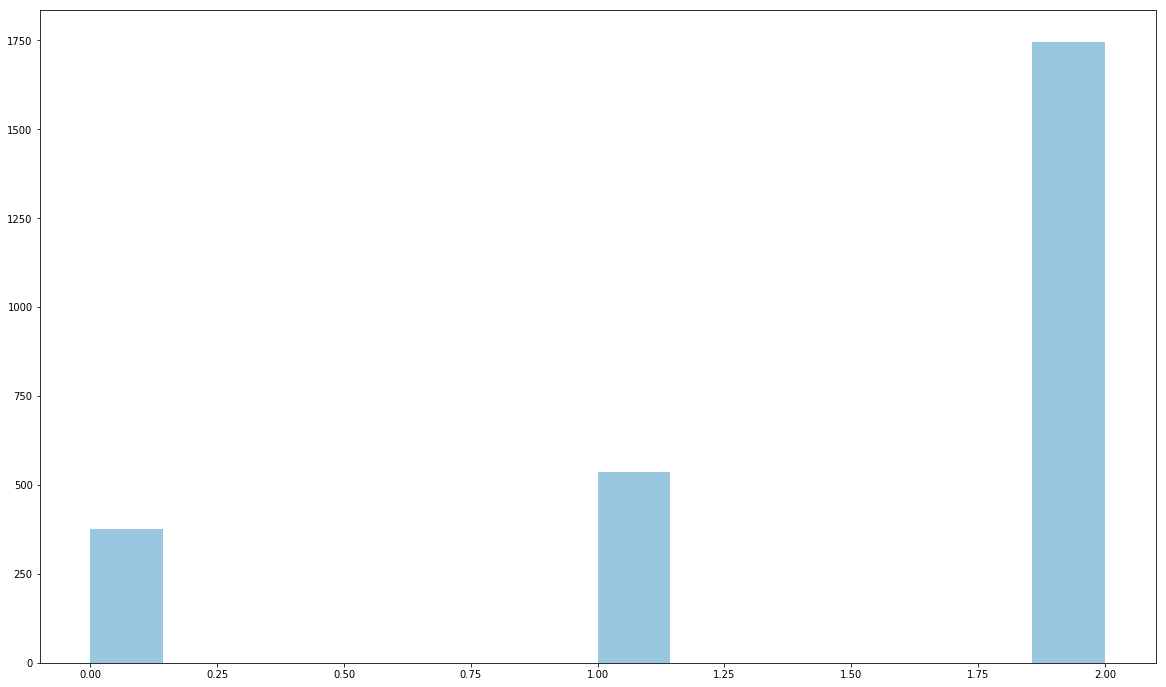

In [232]:
missingness = []
for pid, dates in missing_date_dict.items():
    for date, count in dates.items():
        missingness.append(count)
   
sns.distplot(missingness, norm_hist=False, kde=False)

### Correlations

#### EMA context correlations

In [211]:
context_corr_df = context_df.copy()
context_corr_df = context_corr_df.drop('group', axis='columns')
context_corr_df = context_corr_df.merge(screener_df[['pid', 'score_PHQ', 'score_GAD']], on='pid', how='left')
context_corr_df = context_corr_df.set_index('pid')

In [212]:
corrs, _, p_vals = run_r_corr(context_corr_df)

In [213]:
def build_corr_mat(corrs, p_vals, labels, title, alpha):
    """
    returns the matplotlib plt object for the specified correlations.
    """
    plt.rcParams["figure.figsize"] = [20,12]
    plt.imshow(corrs)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = "{0:.2f}".format(corrs[i, j])
            p = p_vals[i,j]
            if p < alpha:
                text = text + "*"
            plt.text(j,i, text, ha="center", va="center", color="w")
    plt.xticks([x for x in range(len(labels))], labels, rotation=45, ha="right", rotation_mode='anchor')
    plt.yticks([x for x in range(len(labels))], labels)
    plt.colorbar()
    plt.title(title)
    return plt


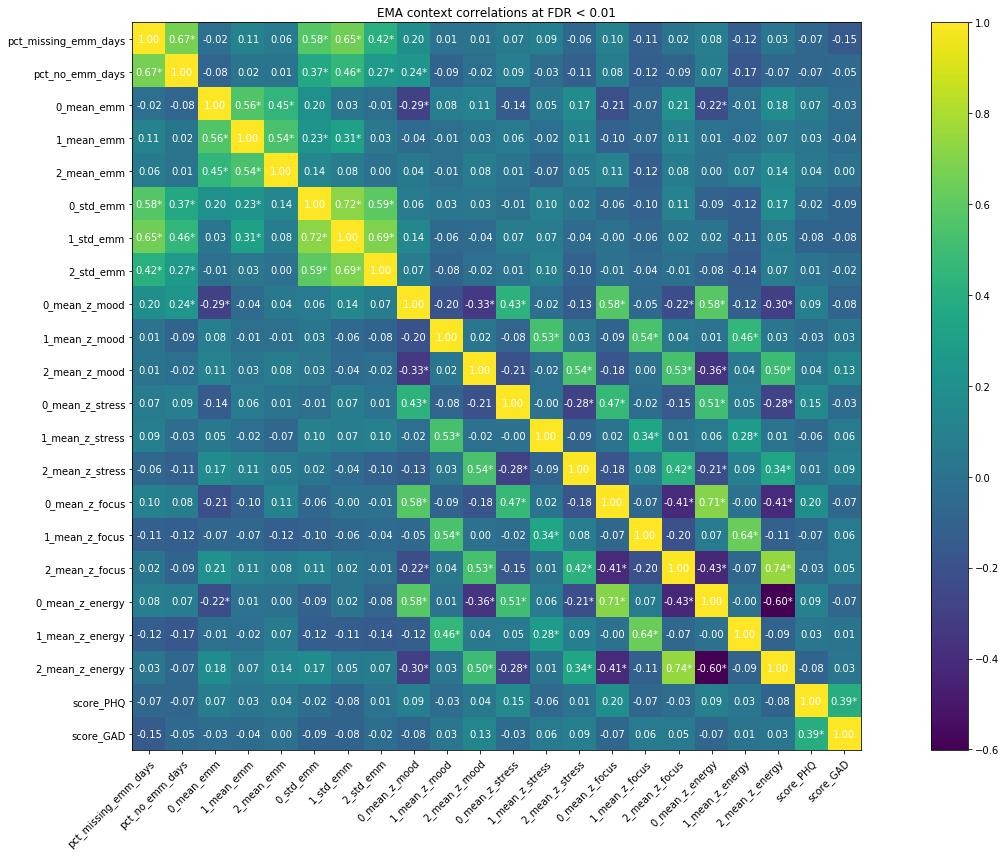

In [215]:
plt = build_corr_mat(corrs, p_vals, context_corr_df.columns.values, 'EMA context correlations at FDR < 0.01', 0.01)
plt.tight_layout()
plt.savefig("figures/context_ema_corr.png", dpi=300)

#### daily EMA correlations

In [237]:
drop_cols = ['pid', 'date', 'cluster', 'loc_var']
emm_day_corr_df = emm_day_df.copy()
emm_day_corr_df = emm_day_corr_df.drop(drop_cols, axis='columns')

In [238]:
corrs, _, p_vals = run_r_corr(emm_day_corr_df)

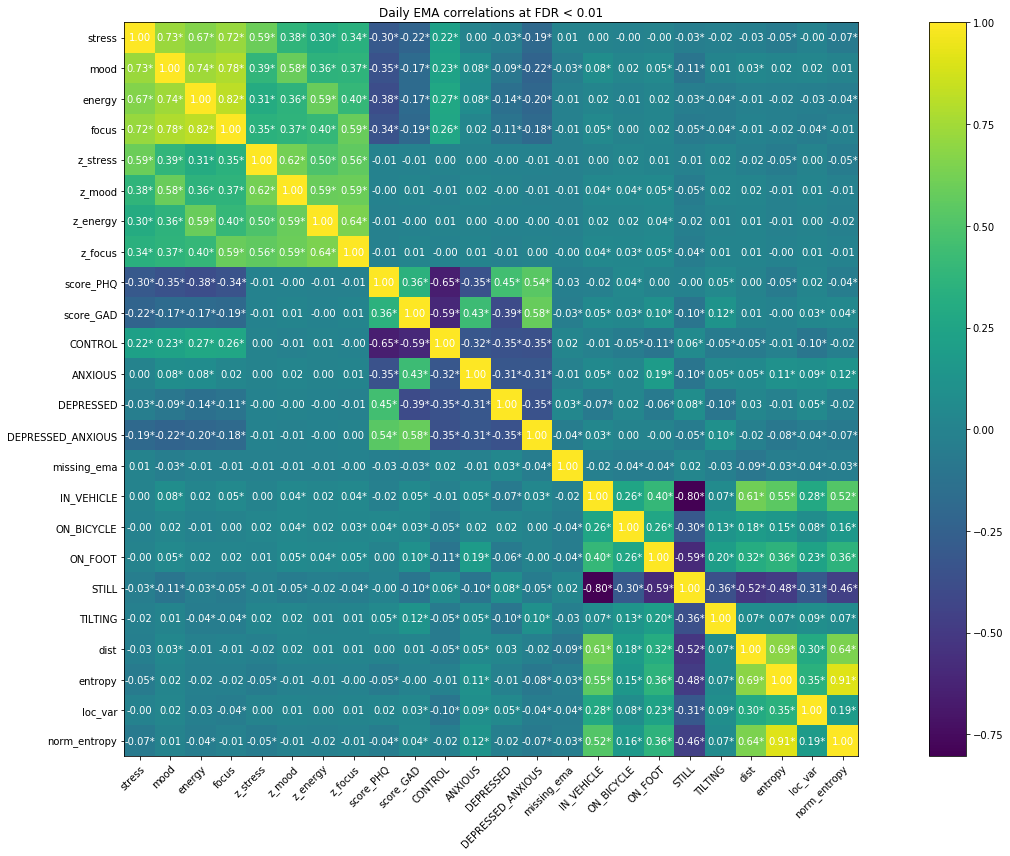

In [239]:
plt = build_corr_mat(corrs, p_vals, emm_day_corr_df.columns.values, 'Daily EMA correlations at FDR < 0.01', 0.01)
plt.tight_layout()
#plt.savefig("figures/daily_ema_corr.png", dpi=300)

- better (raw) mood correlates with lower missingness
- less distance traveled and lower location entropy correlates with lower missingness

## Remarks

- significant correlations between missing EMA surveys and variability in EMA response time
- mood is worst at the first EMA response
- energy and focus is the highest at the second EMA response

### Notes

- slice out hour of EMA response to check correlation?
- want: cross reference of EMA response time with other sensors
- what predicts a day where there is a missing EMA?
    - how to set up this sequence prediction?
    
- should we standardize the EMA responses or not?
- prediction problem: given the characteristics of a day, how many EMAs did the person answer?
- we see greater than 3 EMA responses in instances where the participant missed a survey the previous day

#### TODOs

- ~~figure out missingness of EMA responses~~
- ~~figure out missingness as a function of mood disorder group~~
- ~~ould be a good idea to group everything into those four categories~~
- ~~look at time of first response of the day~~
- ~~look into the regularity of EMA responses (variance in gaps)~~
    - ~~(better?) variance in hour of day~~
- ~~correlations between which EMA response and mean survey responses~~
- ~~get list of days with missing EMA responses~~
    - n~~eed to somehow check days with 0 EMA responses~~
- ~~look at completely missing days~~
- adjust all sensor dataframes by timezone